# Notebook for Home Credit dataset
Author: Johannes Pastorek, johannes.pastorek@gmail.com

## Imports

In [155]:
reset -fs

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt#

from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('seaborn')
np.random.seed(42)

## Functions

In [157]:
def isNaN(num):
    return num != num


def get_col_descr(feature):
    return column_description[column_description.row == feature].loc[:, 'description'].tolist()


def transform_days_feats(cols):
    for col in cols:
        if col in list(X.columns):
            new_col_name = col.split('_')[-1]
            X[new_col_name] = X[col].apply(lambda x: int(x / -365))
            X.drop([col], axis=1, inplace=True)
            print(col + '  =>  ' + new_col_name)
         
        
def remove_nan_cols(cols):
    new_cols = list()
    for col in cols:
        if X[col].isna().sum() == 0:
            new_cols.append(col)
        else:
            X.drop([col], axis=1, inplace=True)
            print('removed column: ' + col)
    return new_cols

## Variable description

In [158]:
c = pd.read_csv('HomeCredit_columns_description.csv', encoding= 'unicode_escape')
cd = c[c.Table == 'application_{train|test}.csv']
cd['Row'] = cd['Row'].apply(lambda x: x.lower())
cd = cd[['Row', 'Description']]
cd = cd.rename({'Row':'Variable', 'Definition':'Definition'})
# cd.head()

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Data Import

In [159]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
train['dataset'], test['dataset'] = 0, 1

X = pd.concat([train,test],sort=True)
X.columns = X.columns.str.lower()

In [164]:
X.isna().sum().sum() / (X.shape[0]*X.shape[1])

0.2420306181981414

## Data Cleaning

In [720]:
# remove features with the following beginnings and endings
'''
back_del = ['avg', 'medi', 'circle']
mid_del = ['document', 'req']
front_del = ['sk', 'cnt', 'weekday', 'hour']
for entry in list(X.drop(['target', 'dataset'], axis=1).columns):
    if entry.split('_')[-1] in back_del:
        X = X.drop([entry], axis=1)
    if entry.split('_')[0] in front_del:
        X = X.drop([entry], axis=1)
    if entry.split('_')[1] in mid_del:
        X = X.drop([entry], axis=1)
'''

"\nback_del = ['avg', 'medi', 'circle']\nmid_del = ['document', 'req']\nfront_del = ['sk', 'cnt', 'weekday', 'hour']\nfor entry in list(X.drop(['target', 'dataset'], axis=1).columns):\n    if entry.split('_')[-1] in back_del:\n        X = X.drop([entry], axis=1)\n    if entry.split('_')[0] in front_del:\n        X = X.drop([entry], axis=1)\n    if entry.split('_')[1] in mid_del:\n        X = X.drop([entry], axis=1)\n"

In [721]:
modes = list()
for col in list(X.columns):
    if col.split('_')[-1] == 'mode':
        modes.append(col)

In [722]:
# X.info(verbose=True, null_counts=True)

### days_ features

In [83]:
days_cols = [x for x in list(X.columns) if (x.split('_')[0] == 'days')]
days_cols = remove_nan_cols(days_cols)

removed column: days_last_phone_change


In [84]:
transform_days_feats(days_cols)

days_birth  =>  birth
days_employed  =>  employed
days_id_publish  =>  publish
days_registration  =>  registration


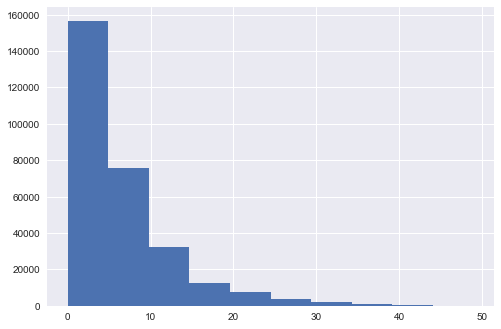

In [85]:
# employed -1000 replace with NaN
X['employed'] = X.employed.apply(lambda x: float('NaN') if x == -1000 else x)
X.employed.hist()

### Remove 'XNA' values

In [86]:
X.groupby('code_gender').count()['target']

code_gender
F      202448
M      105059
XNA         4
Name: target, dtype: int64

In [87]:
for i in X.columns:
    X[i] = X[i].apply(lambda x: float('NaN') if x == 'XNA' else x)

In [88]:
X = X.dropna(subset=['code_gender'])

## EDA

In [89]:
X.head()

,amt_annuity,amt_credit,amt_goods_price,amt_income_total,amt_req_credit_bureau_day,amt_req_credit_bureau_hour,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_week,amt_req_credit_bureau_year,...,years_beginexpluatation_medi,years_beginexpluatation_mode,years_build_avg,years_build_medi,years_build_mode,dataset,birth,employed,publish,registration
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.9722,0.9722,0.6192,0.6243,0.6341,0,25,1.0,5,9
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9851,0.9851,0.7960,0.7987,0.8040,0,45,3.0,0,3
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,52,0.0,6,11
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,52,8.0,6,26
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,54,8.0,9,11


In [728]:
X['mode_nans'] = X[modes].isna().sum(axis=1) == 0
X['mode_nans'] = X['mode_nans'].astype(int)

In [90]:
X['higher_educ'] = X['name_education_type'].apply(lambda x: 
                                                  1 if (x == 'Higher education') | 
                                                       (x == 'Academic degree')  
                                                  else 0
                                                 )

In [91]:
X['term'] = X.amt_annuity / X.amt_credit
X['income_credit'] = X.amt_credit / X.amt_income_total

In [92]:
X = X[['target', 'dataset', 'ext_source_1', 'ext_source_2','ext_source_3', 
       'birth', 'code_gender', 'employed', 'term',
       'higher_educ','own_car_age'
      ]]

In [97]:
X.head()

,target,dataset,ext_source_1,ext_source_2,ext_source_3,birth,employed,term,higher_educ,own_car_age,gender
0,1.0,0,0.083037,0.262949,0.139376,25,1.0,0.060749,0,NaN,1
1,0.0,0,0.311267,0.622246,NaN,45,3.0,0.027598,1,NaN,0
2,0.0,0,NaN,0.555912,0.729567,52,0.0,0.050000,0,26.0,1
3,0.0,0,NaN,0.650442,NaN,52,8.0,0.094941,0,NaN,0
4,0.0,0,NaN,0.322738,NaN,54,8.0,0.042623,0,NaN,1


In [94]:
cat_features = list(X.columns[X.dtypes==object])

In [72]:
'''
X[cat_features] = X[cat_features].fillna('missing')
X['emer_mode_missing'] = X['emergencystate_mode'].apply(lambda x: 1 if x == 'missing' else 0)
X = X.drop(['emergencystate_mode'], axis=1)
'''

"\nX[cat_features] = X[cat_features].fillna('missing')\nX['emer_mode_missing'] = X['emergencystate_mode'].apply(lambda x: 1 if x == 'missing' else 0)\nX = X.drop(['emergencystate_mode'], axis=1)\n"

In [95]:
#X['age_group'] = list(pd.cut(X.birth, bins=[0,35,99], labels=['18-35', '36-99']))
#X = X.drop(['birth'], axis=1)
cat_features = list(X.columns[X.dtypes==object])

In [96]:
#X= X.join(pd.get_dummies(X[cat_features], drop_first=True))
# X.drop(cat_features, axis=1, inplace=True)
X['gender'] = list(pd.get_dummies(X[cat_features], drop_first=True)['code_gender_M'])
X.drop(cat_features, axis=1, inplace=True)

## Feature Engineering

In [76]:
X.head()

,ext_source_1,ext_source_2,ext_source_3,birth,employed,term,higher_educ,own_car_age,gender
0,0.083037,0.262949,0.139376,25,1.0,0.060749,0,NaN,1
1,0.311267,0.622246,NaN,45,3.0,0.027598,1,NaN,0
2,NaN,0.555912,0.729567,52,0.0,0.050000,0,26.0,1
3,NaN,0.650442,NaN,52,8.0,0.094941,0,NaN,0
4,NaN,0.322738,NaN,54,8.0,0.042623,0,NaN,1


In [22]:
X_train = X[X.dataset == 0].drop(['target', 'dataset'], axis=1)
y_train = X[X.dataset == 0].target
X_train.head()

,ext_source_1,ext_source_2,ext_source_3,birth,employed,term,higher_educ,own_car_age,gender
0,0.083037,0.262949,0.139376,25,1.0,0.060749,0,NaN,1
1,0.311267,0.622246,NaN,45,3.0,0.027598,1,NaN,0
2,NaN,0.555912,0.729567,52,0.0,0.050000,0,26.0,1
3,NaN,0.650442,NaN,52,8.0,0.094941,0,NaN,0
4,NaN,0.322738,NaN,54,8.0,0.042623,0,NaN,1


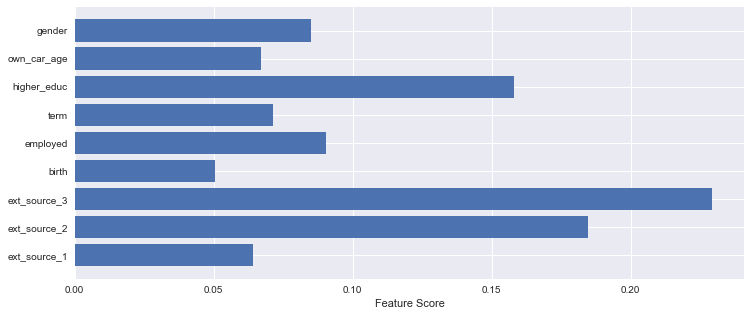

In [136]:
model = XGBClassifier()
model.fit(X_train, y_train)

plt.figure(figsize=(12, 5))
plt.barh(range(len(model.feature_importances_)), model.feature_importances_)
my_yticks = list(X_train.columns)
plt.yticks(list(range(len(my_yticks))), my_yticks)
plt.xlabel('Feature Score')
plt.show()

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


model = XGBClassifier(n_estimators=500, objective = 'binary:logistic', 
                      class_weight = 'balanced', learning_rate = 0.05, 
                      reg_alpha = 0.1, reg_lambda = 0.1, 
                      subsample = 0.8, n_jobs = -1, random_state = 50
                     )

model.fit(X_train, y_train)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=5)
print('Mean ROC AUC: %.3f' % np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  3.6min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  7.0min remaining:  3.5min


Mean ROC AUC: 0.762


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.6min finished


In [ ]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')

submission, fi, metrics = model(train, test)
print('Baseline metrics')
print(metrics)

In [46]:
def model_xgb(features, test_features):
    
    train_ids = features['sk_id_curr']
    test_ids = test_features['sk_id_curr']
    
    labels = features['target']
    features = features.drop(columns = ['sk_id_curr', 'target', 'dataset'])
    test_features = test_features.drop(columns = ['sk_id_curr', 'target','dataset'])
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    feature_names = list(features.columns)
    features = np.array(features)
    test_features = np.array(test_features)
    
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                        test_size=test_size, 
                                                        random_state=seed)
    # fit model on training data
    model = XGBClassifier()
    eval_set = [(X_test, y_test)]
    model.fit(X_train, y_train, 
              early_stopping_rounds=10, 
              eval_metric='auc', 
              eval_set=eval_set, verbose=True)

In [142]:
from sklearn.model_selection import train_test_split

X1 = X[X.dataset == 0].drop(['target', 'dataset'], axis=1)
y = X[X.dataset == 0].target
X.head()

RSTATE = 777
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X1, y, 
                                                    test_size=test_size, 
                                                    random_state=RSTATE)
# fit model on training data
model = XGBClassifier(n_estimators=10000, objective = 'binary:logistic', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = RSTATE)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, 
          early_stopping_rounds=100, 
          verbose=200,
          eval_metric='auc', 
          eval_set=eval_set)

[0]	validation_0-auc:0.665537
Will train until validation_0-auc hasn't improved in 100 rounds.
[200]	validation_0-auc:0.742547
[400]	validation_0-auc:0.751318
[600]	validation_0-auc:0.754001
[800]	validation_0-auc:0.754886
[1000]	validation_0-auc:0.755411
Stopping. Best iteration:
[1064]	validation_0-auc:0.755588



XGBClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=10000,
              n_jobs=-1, random_state=777, reg_alpha=0.1, reg_lambda=0.1,
              subsample=0.8)

In [108]:
X_test = X[X.dataset == 1].drop(['target', 'dataset'], axis=1)

In [ ]:
X_test['target%'] = model.predict_proba(X_test)[:,1]

In [128]:
X_test['target%'] = (X_test['target%'] * 100).astype(int)

In [135]:
X_test['target%'].min()

0

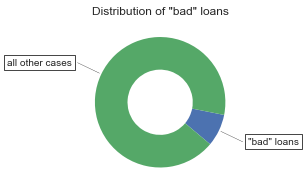

In [154]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ['"bad" loans', 'all other cases']

data = [8, 92]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title('Distribution of "bad" loans')
plt.savefig('targetDistr.png')
plt.show()


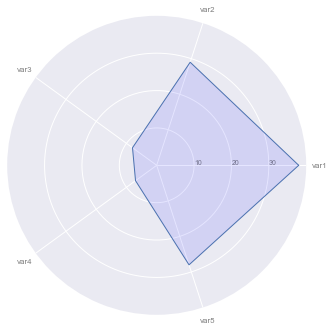

In [165]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

In [170]:
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
df
categories=list(df)[1:]
N = len(categories)

categories

['var1', 'var2', 'var3', 'var4', 'var5']

In [744]:
num_features = list(X.columns[X.dtypes!=object])
num_features.remove('target')

X[num_features] = X[num_features].fillna(X[num_features].median())

X_train = X[X.dataset == 0].drop(['target', 'dataset'], axis=1)
y_train = X[X.dataset == 0].target

In [747]:
X_train.head()

,ext_source_1,ext_source_2,ext_source_3,birth,employed,term,higher_educ,own_car_age,gender
0,0.083037,0.262949,0.139376,25,1,0.060749,0,9.0,1
1,0.311267,0.622246,0.533482,45,3,0.027598,1,9.0,0
2,0.506155,0.555912,0.729567,52,0,0.050000,0,26.0,1
3,0.506155,0.650442,0.533482,52,8,0.094941,0,9.0,0
4,0.506155,0.322738,0.533482,54,8,0.042623,0,9.0,1


In [748]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

model = RandomForestClassifier()
resample = SMOTEENN()
pipeline = Pipeline(steps=[('r', resample), ('m', model)])
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=5)

print('Mean ROC AUC: %.3f' % np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed: 10.2min remaining: 12.7min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 19.7min remaining:  9.9min


Mean ROC AUC: 0.691


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 23.0min finished


In [761]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000, class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=5)

print('Mean ROC AUC: %.3f' % np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   35.4s


Mean ROC AUC: 0.727


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.1min finished


In [774]:
[i/10.0 for i in range(0,5)]

[0.0, 0.1, 0.2, 0.3, 0.4]

In [24]:
#reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
[1e-5, 1e-2, 0.1, 1, 100]

[1e-05, 0.01, 0.1, 1, 100]